# Распознавание лиц (ноутбук)

> Узнаем как можно делать распознавание лиц.

In [1]:
#!g1.1
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
#!g1.1
def _loader(path: str) -> Image.Image:
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')


class Faces(Dataset):
    def __init__(self, root: str, split: str = 'train', transform=None):
        self.root = os.path.join(root, split)

        self.names, self.name2idx, self.idx2name = self._get_names()

        self.images, self.labels = self._get_people()
        self.total_idxs = np.arange(len(self.images))

        self.transform = transform

    def _get_names(self):
        names = list(map(lambda x: int(x), os.listdir(self.root)))

        name2idx = {name: _ for _, name in enumerate(names)}
        idx2name = {_: name for _, name in enumerate(names)}

        return names, name2idx, idx2name

    def _get_people(self):
        images = glob(os.path.join(self.root, '*/*'))
        
        labels = [self.name2idx[int(image.split('/')[-2])] for image in images]

        return np.array(images), np.array(labels)

    def __getitem__(self, item):
        image1 = _loader(self.images[item])

        if np.random.uniform() < 0.5:
            image2 = _loader(np.random.choice(self.images[self.labels == self.labels[item]]))
            label = torch.tensor([1], dtype=torch.float)
        else:
            image2 = _loader(np.random.choice(self.images[self.labels != self.labels[item]]))
            label = torch.tensor([0], dtype=torch.float)

        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return image1, image2, label, torch.tensor([self.labels[item]], dtype=torch.int)

    def __len__(self):
        return len(self.images)

In [3]:
#!g1.1
dataset = Faces('faces_dataset')

In [4]:
#!g1.1
dataset[0]

(<PIL.Image.Image image mode=L size=92x112>,
 <PIL.Image.Image image mode=L size=92x112>,
 tensor([1.]),
 tensor([0], dtype=torch.int32))

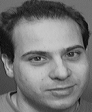

In [5]:
#!g1.1
dataset[0][0]

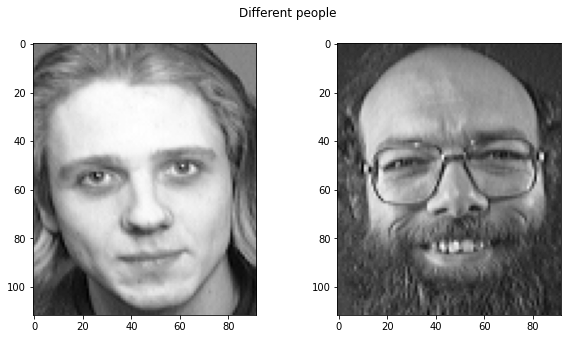

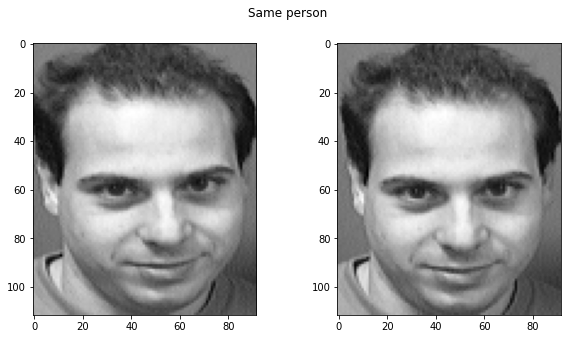

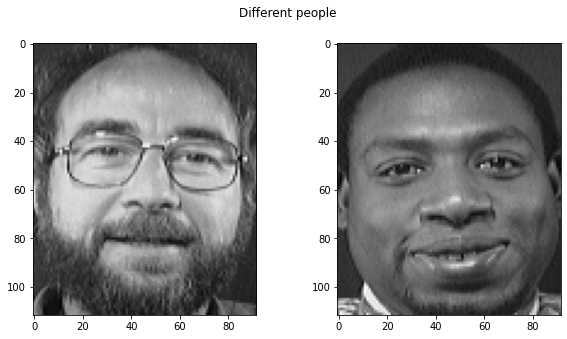

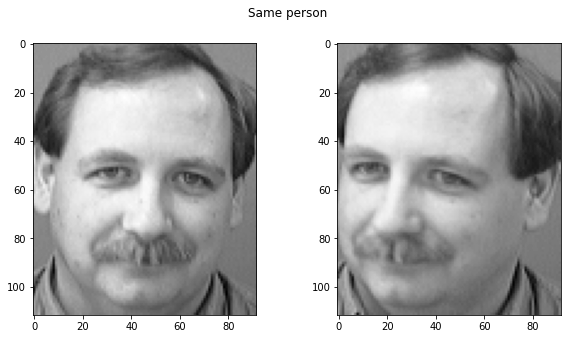

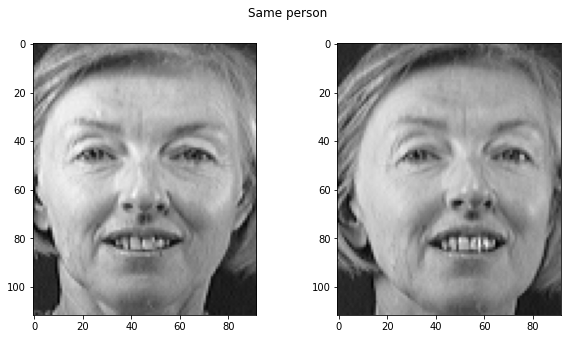

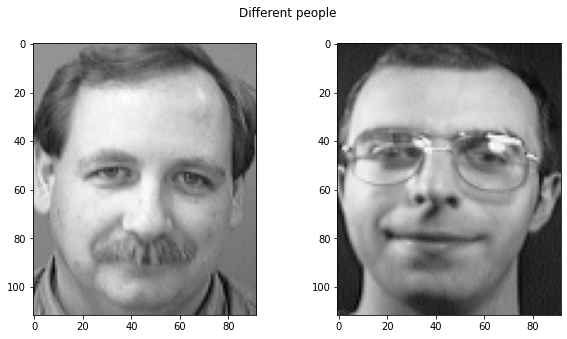

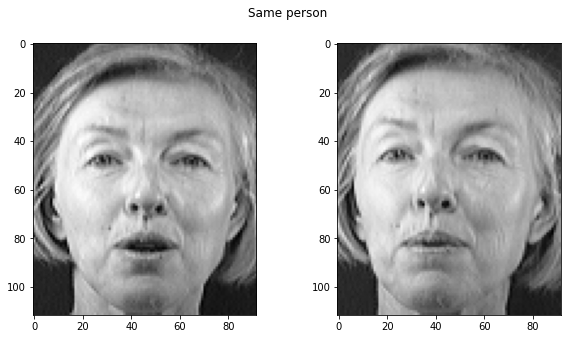

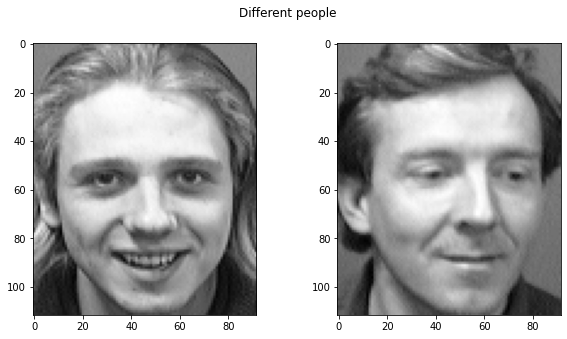

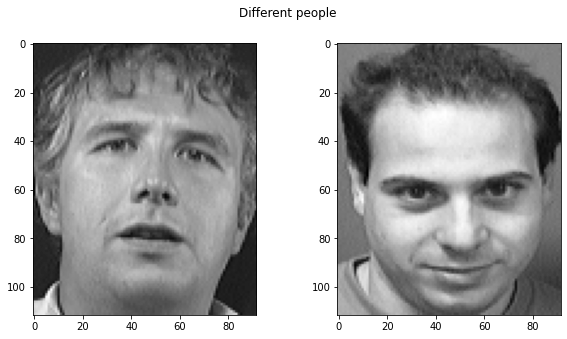

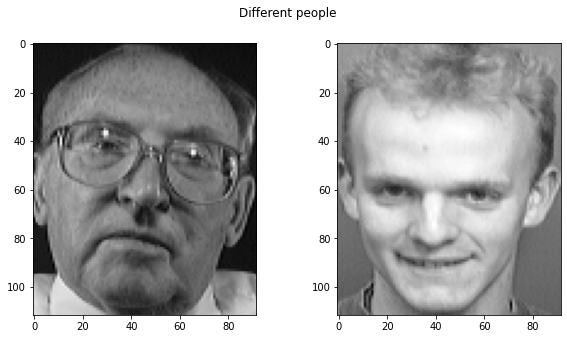

In [6]:
#!g1.1
for i in np.random.randint(len(dataset), size=10):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    img1, img2, label, _ = dataset[i]
    
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')
    
    fig.suptitle('Same person' if label.item() else 'Different people')
    
    plt.show()

In [7]:
#!g1.1
train_transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.RandomHorizontalFlip(),
        T.ToTensor()
    ]
)

test_transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor()
    ]
)

In [8]:
#!g1.1
train_dataset = Faces('faces_dataset', 'train', transform=train_transform)
valid_dataset = Faces('faces_dataset', 'test', transform=test_transform)

In [9]:
#!g1.1
train_dataset[0][0].shape

torch.Size([1, 128, 128])

In [10]:
#!g1.1
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    pin_memory=True,
    num_workers=8,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    pin_memory=True,
    shuffle=False
)

len(train_loader)

3

In [11]:
#!g1.1
import torch.nn.functional as F


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, x1, x2, y):
        dist = F.pairwise_distance(x1, x2, keepdim = True)

        return torch.mean(
            y * torch.pow(dist, 2) +
            (1 - y) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)
        )

In [12]:
#!g1.1
class ContrastiveModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.MaxPool2d(2),  # 64
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.MaxPool2d(2),  # 32
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.MaxPool2d(2),  # 16
            
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(16 * 16 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward_single(self, x):
        return self.fc(self.feature_extractor(x))

    def forward(self, x1, x2):
        return self.forward_single(x1), self.forward_single(x2)

In [13]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla V100-SXM2-32GB


In [14]:
#!g1.1
from tqdm import tqdm


def train(model, optimizer, loader, loss_fn) -> float:
    model.train()

    train_loss = 0

    for x1, x2, y, _ in tqdm(loader, desc='Train'):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)

        optimizer.zero_grad()
        
        output1, output2 = model(x1, x2)

        loss = loss_fn(output1, output2, y)

        loss.backward()
        
        train_loss += loss.item()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [15]:
#!g1.1
@torch.inference_mode()
def get_latent_base(model):
    model.eval()

    xs = []
    ys = []
    zs = []

    for x, _, _, y in train_loader:
        z = model.forward_single(x.to(device))

        xs.append(x.cpu())
        ys.append(y)
        zs.append(z)

    xs = torch.cat(xs)
    ys = torch.cat(ys)
    zs = torch.cat(zs)
    
    return xs, ys, zs


@torch.inference_mode()
def evaluate(model):
    model.eval()
    
    xs, ys, zs = get_latent_base(model)
    
    total = 0
    correct = 0

    for i, (x, _, _, y) in tqdm(enumerate(valid_loader), desc='Evaluation'):
        z = model.forward_single(x.to(device))

        dists = F.pairwise_distance(z, zs)

        idx = torch.argmin(dists)

        correct += ys[idx].item() == y.item()
        total += 1

    return correct / total

In [16]:
#!g1.1
def plot_stats(
    train_loss: list[float],
    test_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.legend()
    plt.grid()

    plt.show()
    
    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [17]:
#!g1.1
def train_cycle(model, optimizer, loss_fn, num_epochs, title):
    train_loss_history, test_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model, optimizer, train_loader, loss_fn)
        test_accuracy = evaluate(model)

        train_loss_history.append(train_loss)
        test_accuracy_history.append(test_accuracy)

        lr_shed.step(train_loss)

        clear_output()

        plot_stats(
            train_loss_history, test_accuracy_history,
            title
        )

In [18]:
#!g1.1
model = ContrastiveModel().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_fn = ContrastiveLoss()

lr_shed = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

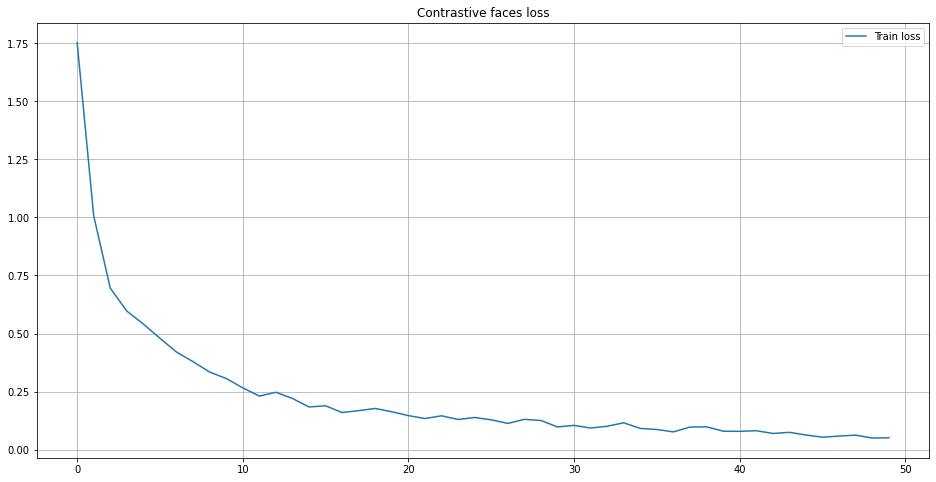

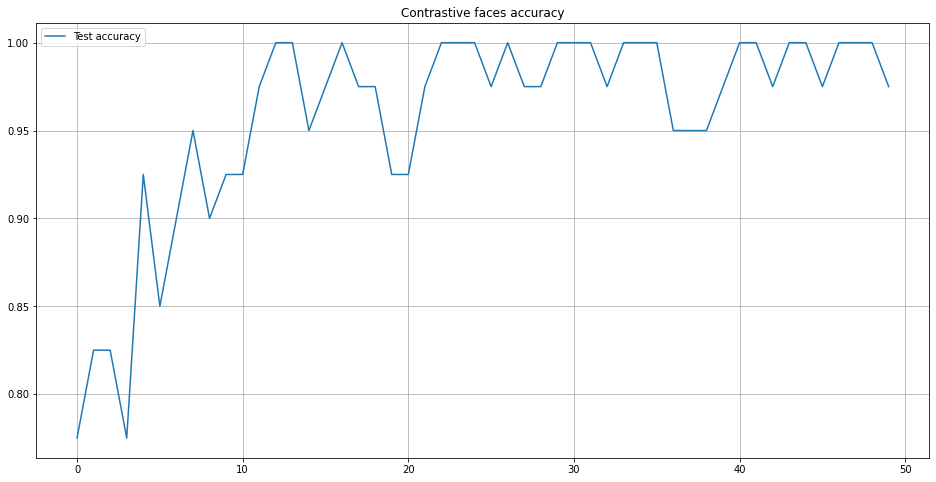

In [19]:
#!g1.1
train_cycle(model, optimizer, loss_fn, 50, 'Contrastive faces')

In [20]:
#!g1.1
xs, ys, zs = get_latent_base(model)

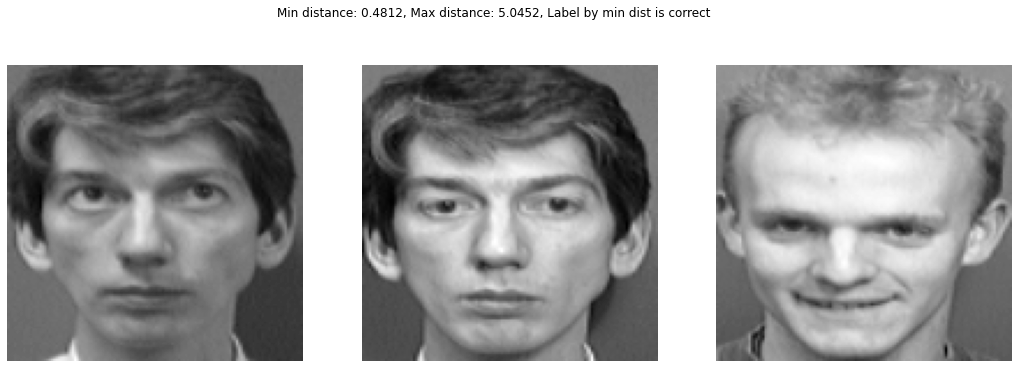

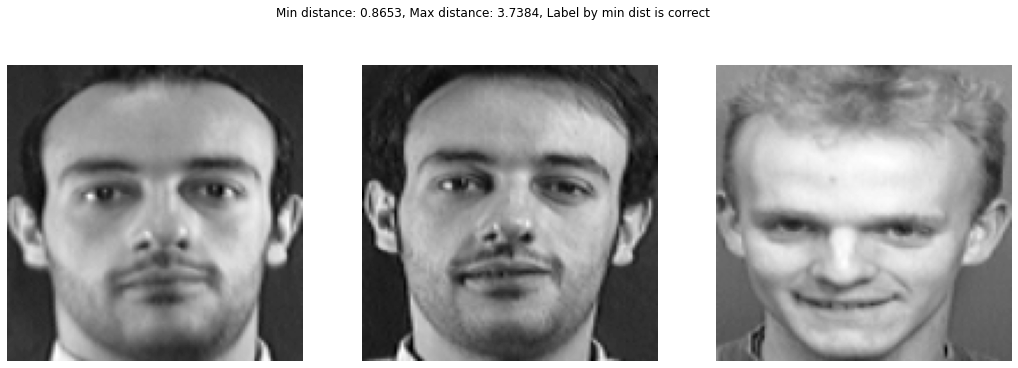

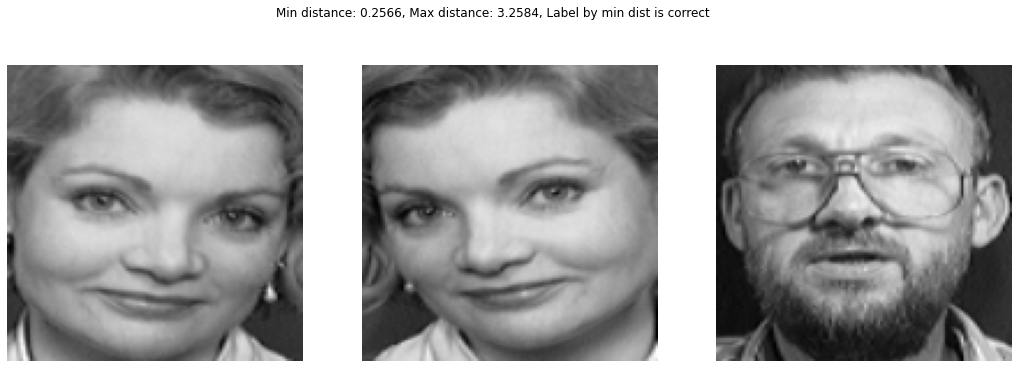

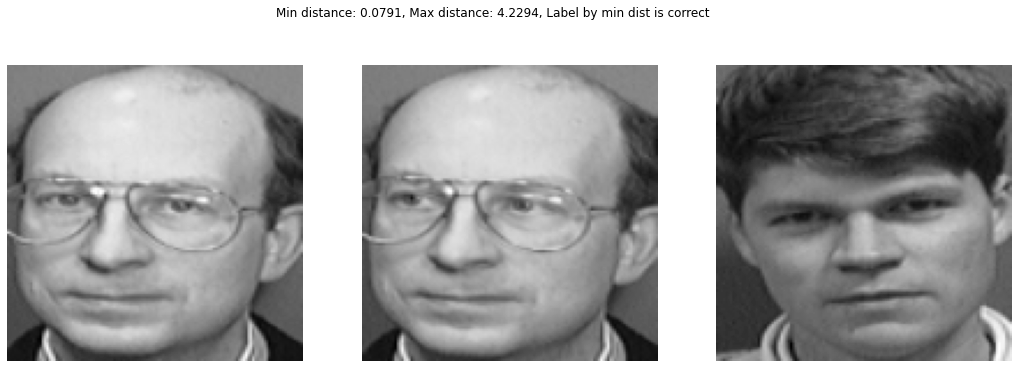

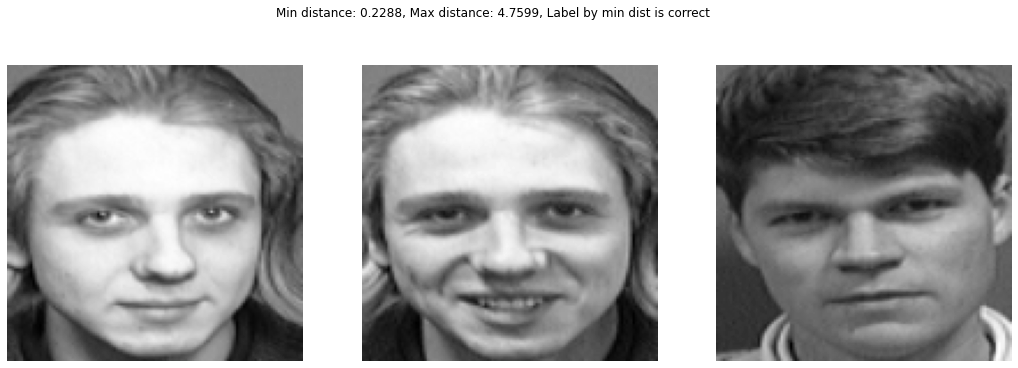

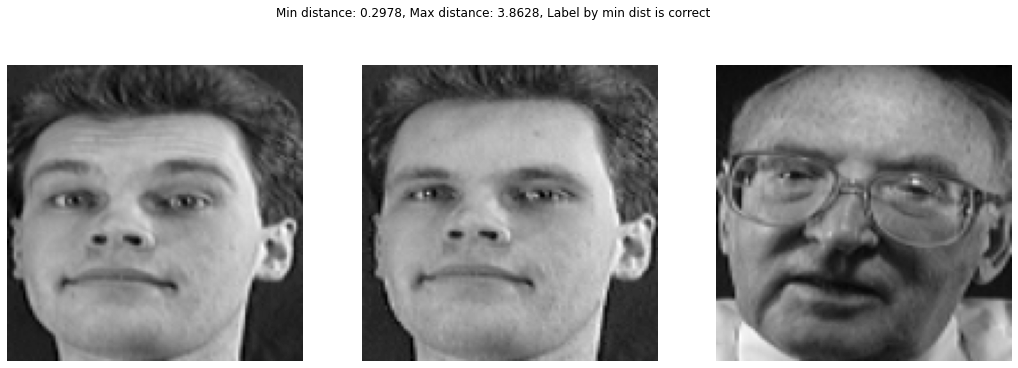

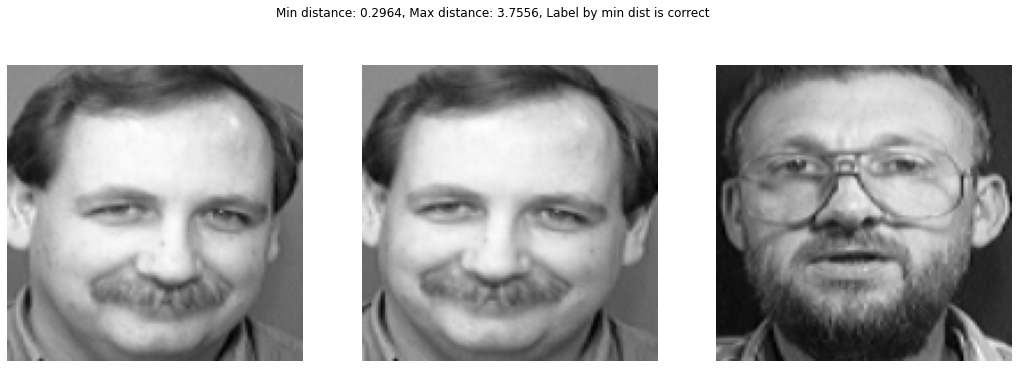

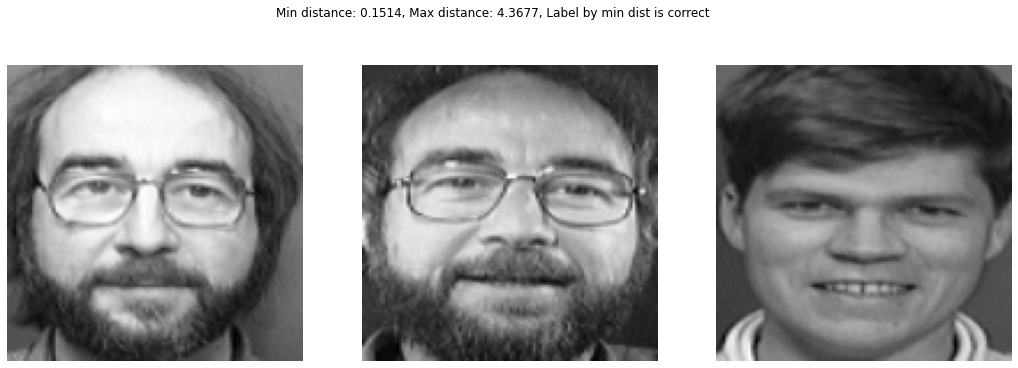

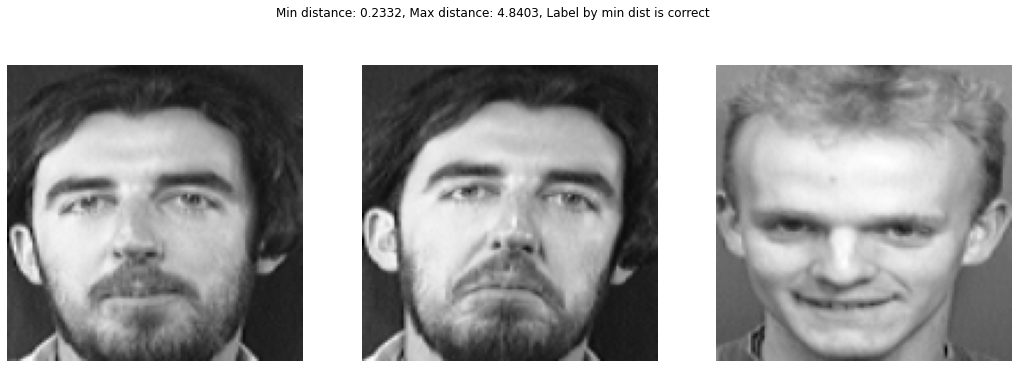

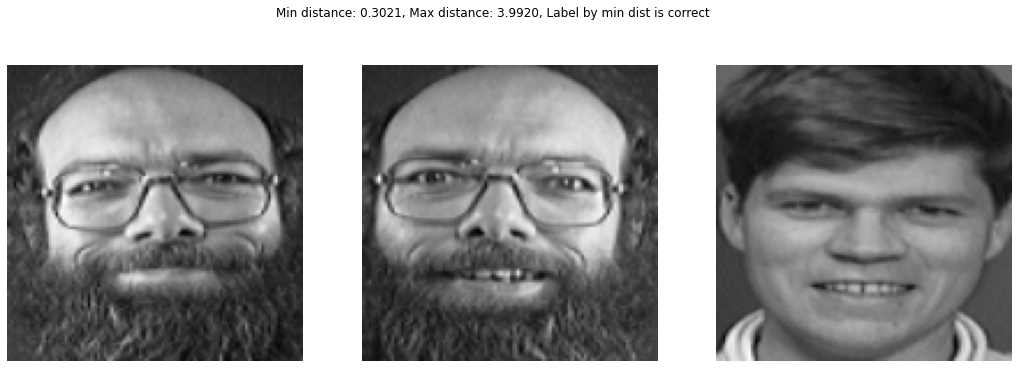

In [21]:
#!g1.1
model.eval()

to_pil = T.ToPILImage()


for i in np.random.randint(len(valid_dataset), size=10):
    x, _, _, label = valid_dataset[i]

    with torch.inference_mode():
        z = model.forward_single(x.unsqueeze(0).to(device))

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    dists = F.pairwise_distance(z, zs)

    idx1 = torch.argmin(dists)
    idx2 = torch.argmax(dists)

    ax[0].imshow(to_pil(x), cmap='gray')
    ax[1].imshow(to_pil(xs[idx1]), cmap='gray')
    ax[2].imshow(to_pil(xs[idx2]), cmap='gray')

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

    fig.suptitle(f'Min distance: {dists[idx1].item():.4f}, Max distance: {dists[idx2].item():.4f}, Label by min dist is {"correct" if ys[idx1].item() == label.item() else "incorrect"}')

    plt.show()